In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, get_linear_schedule_with_warmup, TrainingArguments, Trainer
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import Dataset
from datasets import load_metric
import numpy as np
from transformers import pipeline
import random
import tensorflow as tf
import pandas as pd
import csv
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from keras import regularizers
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE


In [2]:
from datasets import *
# device = "mps"
# device_map = {"": "gpu"}

# 数据整理

In [3]:
file_path = "Data_enhanced/enhanced_Cross_dataset.csv"

## 导入

In [5]:
# with open(filepath, 'r', encoding='utf-8') as file:
def read_csv_as_list(file_path):
  data = []
  with open(file_path, 'r', newline='', encoding='gbk',errors='replace') as file:
    csv_reader = csv.reader(file)
    first_row = True
    for row in csv_reader:
      if first_row:  
        first_row = False
        continue
      data.append(row)
  return data

In [6]:
csv_data = read_csv_as_list(file_path)
# print(csv_data)

In [7]:
csv_data[0]

['  The DPU-BOOT CSC shall include a DRAM BIT consisting of two write/read/compare tests.  The first test shall write the address of each memory location to that location.  The second test shall write the complement of each memory location to that location.',
 'initial boot sequencethe initial boot sequence, identified as Boot Sequence 1.  This processing takes place when the Bootstrap executes from Programmable Read-Only Memory (PROM).  Boot Sequence 1 is composed primarily of 4 steps as follows.First, in this sequence, EEPROM is updated.  Then, CPU BIT and a portion of DRAM BIT is performed.  Next, DRAM is cleared.  Lastly, Boot Sequence 2 is copied to DRAM and executed. During this sequence, the rest of DRAM is tested if skipBit is not set.  Load parameters are put into registers r13, r14, r15 and r16.  DRAM is cleared up to memSize.  Lastly, either the DPU-RTOS or the Bootstrap Monitor is loaded and executed according to the load parameters.',
 '1']

In [8]:
random.shuffle(csv_data)

In [9]:
csv_data[5]

['  The DPU-ICUI shall compute a CHKS_16 for DPU_CMDs received from the ICU.  If the expected checksum is not computed, the command will be discarded, an error will be enqueued to DPU-CCM, and a NAK message transmitted to the ICU within a second.',
 'The HTTrack archive file format and link strategy may vary from version to version of HTTrack, therefore it shall be possible to adapt the migration scripts to deal with these changes.',
 '0']

In [10]:
# csv_data = csv_data[:1000]

In [11]:
dataset_array = np.array(csv_data)

In [12]:
# index_column = np.arange(dataset_array.shape[0]).reshape(-1, 1)
# dataset_with_index = np.hstack((index_column, dataset_array))

# dataset_array = np.transpose(dataset_with_index)
# dataset = tf.data.Dataset.from_tensor_slices(dataset_array)
df = pd.DataFrame(dataset_array, columns=["high_requirement", "low_requirement", "label"])
arrow_dataset = Dataset.from_pandas(df)
datasets = arrow_dataset.train_test_split(test_size=0.2)

In [13]:
# from torch.utils.data import random_split
# trainset, validset = random_split(arrow_dataset, lengths=[0.7, 0.3])

In [14]:
arrow_dataset

Dataset({
    features: ['high_requirement', 'low_requirement', 'label'],
    num_rows: 2647
})

## 数据处理函数定义

In [15]:
tokenizer_name_or_path = "meta-llama/Llama-2-7b"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name_or_path)

In [16]:
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

def process_function(examples,tokenizer=tokenizer):
    tokenized_examples = tokenizer(examples["high_requirement"], examples["low_requirement"], 
                                   max_length=256, padding="max_length", truncation=True,return_tensors="pt")
    tokenized_examples["labels"] = [int(label) for label in examples["label"]]
    return tokenized_examples

In [17]:
processed_datasets = datasets.map(
    process_function,
    batched=True,  
    num_proc=4,   
    remove_columns=datasets["train"].column_names, #remove unprocessed column for training

)

Map (num_proc=4):   0%|          | 0/2117 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/530 [00:00<?, ? examples/s]

In [18]:
processed_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2117
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 530
    })
})

In [19]:
len(processed_datasets["train"]["input_ids"][0])

256

# CNN

In [20]:
# import tensorflow as tf
# from tensorflow.keras import layers, models


# def create_model(input_shape):
#     input_ids = layers.Input(shape=input_shape)
#     attention_mask = layers.Input(shape=input_shape)
    

#     x = layers.Concatenate()([input_ids, attention_mask])
    
#     x = layers.Conv1D(64, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.MaxPooling1D(2)(x)
    
#     x = layers.Conv1D(128, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.MaxPooling1D(2)(x)
    
#     x = layers.Conv1D(256, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.MaxPooling1D(2)(x)
    
#     x = layers.Conv1D(512, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.MaxPooling1D(2)(x)
    
#     x = layers.Flatten()(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(128, activation='relu')(x)
#     output = layers.Dense(1, activation='sigmoid')(x) 
    
#     model = models.Model(inputs=[input_ids, attention_mask], outputs=output)
#     return model


# LSTM

In [21]:
# import tensorflow as tf
# from tensorflow.keras import layers, models


# def create_model(input_shape):
#     input_ids = layers.Input(shape=input_shape)
#     attention_mask = layers.Input(shape=input_shape)
#     x = layers.Concatenate()([input_ids, attention_mask])

#     x = layers.LSTM(32, return_sequences=True)(x)
#     x = layers.Dropout(0.2)(x)
#     x = layers.LSTM(64, return_sequences=True)(x)
#     x = layers.Dropout(0.2)(x)
#     x = layers.LSTM(128, return_sequences=True)(x)
    

#     x = layers.Flatten()(x)
# #     x = layers.Dense(128, activation='relu')(x)
# #     x = layers.Dense(16, activation='relu')(x)
    

#     output_tensor = layers.Dense(1, activation='sigmoid')(x)  
    
#     model = models.Model(inputs=[input_ids, attention_mask], outputs=output_tensor)
#     return model

# MLP

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models


def create_model(input_shape):
    input_ids = layers.Input(shape=input_shape)
    attention_mask = layers.Input(shape=input_shape)
    x = layers.Concatenate()([input_ids, attention_mask])
    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    

    output_tensor = layers.Dense(1, activation='sigmoid')(x) 
    
    
    model = models.Model(inputs=[input_ids, attention_mask], outputs=output_tensor)
    return model

In [23]:
input_shape = (256, 1) 
model = create_model(input_shape)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 1)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 1)]             0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 256, 2)               0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 512)                  0         ['concatenate[0][0]']    

In [24]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.01),  
              loss='binary_crossentropy', 
              metrics = ['accuracy']
             )

In [25]:
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.1,min_lr=0.000001)

In [26]:
train_input_ids = np.array(processed_datasets["train"]["input_ids"])
train_attention_mask = np.array(processed_datasets["train"]["attention_mask"])
train_labels = np.array(processed_datasets["train"]["labels"])

test_input_ids = np.array(processed_datasets["test"]["input_ids"])
test_attention_mask = np.array(processed_datasets["test"]["attention_mask"])
test_labels = np.array(processed_datasets["test"]["labels"])

history = model.fit(
    [train_input_ids, train_attention_mask],  
    train_labels, 
    epochs=30,
    callbacks=[lr_reduce],
    batch_size=16,
    validation_data=([test_input_ids, test_attention_mask], test_labels),
    shuffle=True
)
 

Epoch 1/30


133/133 [==============================] - 1s 4ms/step - loss: 785.3655 - accuracy: 0.5257 - val_loss: 2.5609 - val_accuracy: 0.4170 - lr: 0.0100
Epoch 2/30
133/133 [==============================] - 0s 2ms/step - loss: 3.1573 - accuracy: 0.5739 - val_loss: 0.7370 - val_accuracy: 0.5887 - lr: 0.0100
Epoch 3/30
133/133 [==============================] - 0s 3ms/step - loss: 1.2466 - accuracy: 0.5952 - val_loss: 0.7050 - val_accuracy: 0.5906 - lr: 0.0100
Epoch 4/30
133/133 [==============================] - 0s 2ms/step - loss: 0.8778 - accuracy: 0.6009 - val_loss: 0.7041 - val_accuracy: 0.5925 - lr: 0.0100
Epoch 5/30
133/133 [==============================] - 0s 2ms/step - loss: 0.6973 - accuracy: 0.6051 - val_loss: 0.7042 - val_accuracy: 0.5925 - lr: 0.0100
Epoch 6/30
133/133 [==============================] - 0s 3ms/step - loss: 0.7471 - accuracy: 0.6032 - val_loss: 0.7045 - val_accuracy: 0.5925 - lr: 0.0100
Epoch 7/30
133/133 [==============================] - 0s 2ms/step 

In [27]:
print(model.evaluate([test_input_ids, test_attention_mask],test_labels))

17/17 [==============================] - 0s 1ms/step - loss: 0.6895 - accuracy: 0.5925
[0.6895357370376587, 0.5924528241157532]


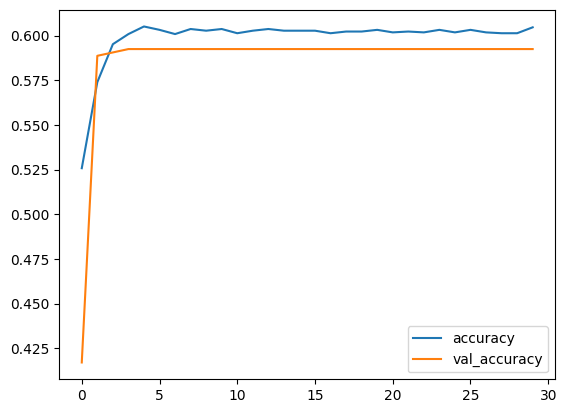

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.epoch, history.history.get('accuracy'),label='accuracy')
plt.plot(history.epoch, history.history.get('val_accuracy'),label='val_accuracy')
plt.legend()

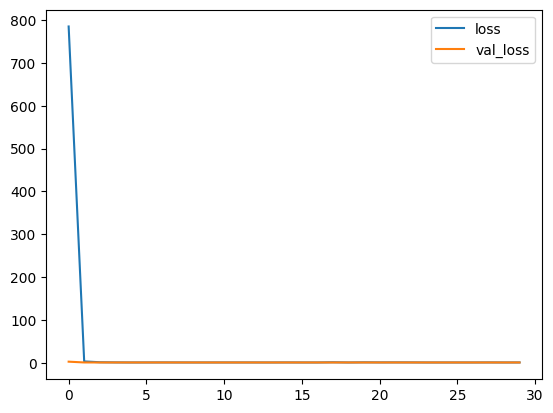

In [29]:
plt.plot(history.epoch, history.history.get('loss'),label='loss')
plt.plot(history.epoch, history.history.get('val_loss'),label='val_loss')
plt.legend()

In [30]:
from sklearn.metrics import classification_report


predict = model.predict([test_input_ids, test_attention_mask])
y_pred = np.argmax(predict, axis=1)


print(classification_report(y_true=test_labels, y_pred=y_pred,digits=4))


17/17 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.5943    1.0000    0.7456       315
           1     0.0000    0.0000    0.0000       215

    accuracy                         0.5943       530
   macro avg     0.2972    0.5000    0.3728       530
weighted avg     0.3532    0.5943    0.4431       530



E:\anconda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anconda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anconda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
